# Topic Modelling

In [1]:
import os
import re
import pickle

from pprint import pprint
import numpy as np
import pandas as pd
from konlpy.tag import Komoran
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
from IPython.core.display import HTML
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

from src.env import PROJECT_DIR


pyLDAvis.enable_notebook(local=True)
plt.rcParams["font.family"] = 'NanumBarunGothic'

C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [29]:
with open(PROJECT_DIR / 'data' / 'interim' / 'all_articles_1.pkl', 'rb') as fp:
    dfs = pickle.load(fp)

## Vectorize data

### POS tagging
형태소 분석기 확인

In [73]:
komo = Komoran()
pos_tagged = np.array(komo.pos('이는 경기도가 부동산 안정화의 해법으로 수차례 강조한 ‘경기도 기본주택 공급’과 ‘기본소득토지세 신설’ 등 부동산 정책들이 신뢰를 갖도록 하는 사전 포석으로 풀이된다.'))

In [7]:
print(pos_tagged)

[['이' 'NP']
 ['는' 'JX']
 ['경기도' 'NNP']
 ['가' 'JKS']
 ['부동산' 'NNP']
 ['안정' 'NNG']
 ['화' 'XSN']
 ['의' 'JKG']
 ['해법' 'NNG']
 ['으로' 'JKB']
 ['수차례' 'NNG']
 ['강조' 'NNG']
 ['하' 'XSV']
 ['ㄴ' 'ETM']
 ['‘' 'SS']
 ['경기도' 'NNP']
 ['기본' 'NNG']
 ['주택' 'NNG']
 ['공급' 'NNG']
 ['’' 'SS']
 ['과' 'JC']
 ['‘' 'SS']
 ['기본소득' 'NNP']
 ['토지세' 'NNG']
 ['신설' 'NNG']
 ['’' 'SS']
 ['등' 'NNB']
 ['부동산' 'NNP']
 ['정책' 'NNG']
 ['들' 'XSN']
 ['이' 'JKS']
 ['신뢰' 'NNG']
 ['를' 'JKO']
 ['갖' 'VV']
 ['도록' 'EC']
 ['하' 'VV']
 ['는' 'ETM']
 ['사전' 'NNG']
 ['포석' 'NNG']
 ['으로' 'JKB']
 ['풀이' 'NNG']
 ['되' 'XSV']
 ['ㄴ다' 'EF']
 ['.' 'SF']]


In [20]:
pos_tagged[:, 1]

array(['NP', 'JX', 'NNP', 'JKS', 'NNP', 'NNG', 'XSN', 'JKG', 'NNG', 'JKB',
       'NNG', 'NNG', 'XSV', 'ETM', 'SS', 'NNP', 'NNG', 'NNG', 'NNG', 'SS',
       'JC', 'SS', 'NNP', 'NNG', 'NNG', 'SS', 'NNB', 'NNP', 'NNG', 'XSN',
       'JKS', 'NNG', 'JKO', 'VV', 'EC', 'VV', 'ETM', 'NNG', 'NNG', 'JKB',
       'NNG', 'XSV', 'EF', 'SF'], dtype='<U4')

#### 명사, 동사, 형용사/adverb만 포함

In [70]:
def exclude_jex(tag):
    return not (tag.startswith('J') or tag.startswith('E') or tag.startswith('X'))

exclude_jex_vec = np.vectorize(exclude_jex)

In [27]:
pos_tagged[exclude_jex_vec(pos_tagged[:, 1]), 0].tolist()

['이',
 '경기도',
 '부동산',
 '안정',
 '해법',
 '수차례',
 '강조',
 '경기도',
 '기본',
 '주택',
 '공급',
 '기본소득',
 '토지세',
 '신설',
 '등',
 '부동산',
 '정책',
 '신뢰',
 '갖',
 '하',
 '사전',
 '포석',
 '풀이']

In [2]:
def extract_noun_verb_adj(sentence):
    tagged = np.asarray(komo.pos(sentence))
    mask = exclude_jex_vec(tagged[:, 1])
    return tagged[mask, 0].tolist()

In [74]:
model_suffix = "noun_verb_adjs"

for k, v in dfs.items():
    dfs[k].loc[:, 'morphs-EJX'] = v.text.apply(extract_noun_verb_adj)
    print(f"{k} done.")

경향신문 done.
동아일보 done.
조선일보 done.
한겨레 done.


#### 모든 형태소 포함

In [10]:
model_suffix = "morphs"

for k, v in dfs.items():
    dfs[k].drop(['morphs'], axis=1, inplace=True)
    dfs[k].loc[:, 'morphs'] = v.text.apply(komo.morphs)
    print(f"{k} done.")

경향신문 done.
동아일보 done.
조선일보 done.
한겨레 done.


In [11]:
model_suffix = "morphs"

Save!

In [75]:
with open(PROJECT_DIR / 'data' / 'processed' / f'all_articles_1-{model_suffix}.pkl', 'wb') as fp:
    pickle.dump(dfs, fp)

## Vectorize with TF-IDF

Get TF-IDF representation vectors

In [2]:
print("Which set of tokens?")
print("[1] all morphs")
print("[2] only nouns, verbs, adjectives and adverbs (and 외국어)")
model_suffix_choice = None
while model_suffix_choice not in [1, 2]:
    print(">>> ", end="")
    model_suffix_choice = int(input())
model_suffix_dict = {1: 'morphs', 2: 'noun_verb_adjs'}
model_suffix = model_suffix_dict[model_suffix_choice]
print(f"model_suffix = {model_suffix}")

Which set of tokens?
[1] all morphs
[2] only nouns, verbs, adjectives and adverbs (and 외국어)
>>> 

 2


model_suffix = noun_verb_adjs


In [3]:
with open(PROJECT_DIR / 'data' / 'processed' / f'all_articles_1-{model_suffix}.pkl', 'rb') as fp:
    dfs = pickle.load(fp)

Compare BC vs. AD

In [4]:
split_date = pd.Timestamp(2020, 2, 25)

In [5]:
print(split_date)

2020-02-25 00:00:00


In [6]:
docs_tokenized_before = dict()
docs_tokenized_after = dict()

for k, v in dfs.items():
    
    docs_tokenized_before[k] = v.loc[v.index < split_date, 'morphs-EJX'].tolist()
    docs_tokenized_after[k] = v.loc[v.index >= split_date, 'morphs-EJX'].tolist()

all_docs_tokenized_before = [x for y in docs_tokenized_before.values() for x in y]
all_docs_tokenized_after = [x for y in docs_tokenized_after.values() for x in y]
all_docs_tokenized = all_docs_tokenized_before + all_docs_tokenized_after

Set max_features=2000 since we have < 2100 documents

In [7]:
max_features = 10000
max_df = 0.4
min_df = 5
ngram_range = (1, 2)

save_path = PROJECT_DIR / "models" / f"tfidf-max_features-{max_features}-max_df-{max_df}-min_df-{min_df}-ngrams-{ngram_range[1]}-{model_suffix}.pkl"
if os.path.exists(save_path):
    with open(save_path, "rb") as fp:
        tfidf_vectorizer = pickle.load(fp)
    dtm_tfidf = tfidf_vectorizer.transform([' '.join(x) for x in all_docs_tokenized])
else:
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, ngram_range=ngram_range)

    dtm_tfidf = tfidf_vectorizer.fit_transform([' '.join(x) for x in all_docs_tokenized])

    with open(save_path, "wb") as fp:
        pickle.dump(tfidf_vectorizer, fp)

In [8]:
print(tfidf_vectorizer)
print("Vocabulary size: ", len(tfidf_vectorizer.vocabulary_))

TfidfVectorizer(max_df=0.4, max_features=10000, min_df=5, ngram_range=(1, 2))
Vocabulary size:  10000


# LDA

In [25]:
lda_tfidf = LatentDirichletAllocation(n_components=15, random_state=0)
lda_tfidf.fit(dtm_tfidf)

lda_vis = pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer, mds='tsne')
lda_vis

C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
12     114.344879  114.308296       1        1  65.145908
10     105.821045  -93.749626       2        1  16.067348
3     -138.334473   95.320763       3        1  10.644783
4       -7.436697  111.259697       4        1   1.167604
7     -207.550629 -105.472603       5        1   0.911486
5       52.817650   14.603765       6        1   0.889258
2      168.010849    6.806950       7        1   0.743491
14     -94.169601 -157.789551       8        1   0.612427
8     -122.849174  -39.059418       9        1   0.569715
0      -94.894264  195.408295      10        1   0.558706
9       24.927401 -180.464874      11        1   0.552457
11     -53.413467   26.832108      12        1   0.539173
13     -12.255850  -72.093201      13        1   0.534113
6     -224.217957   28.070581      14        1   0.532216
1       36.154255  209.427582      15        1   0.531315, topic_info=         Term      Freq      Total Category  logprob  loglift
7240       재난  63.00000  63.000000  Default  30.0000  30.0000
8380      지원금  29.00000  29.000000  Default  29.0000  29.0000
7244  재난 기본소득  37.00000  37.000000  Default  28.0000  28.0000
1227       공약  21.00000  21.000000  Default  27.0000  27.0000
912       경기도  36.00000  36.000000  Default  26.0000  26.0000
...       ...       ...        ...      ...      ...      ...
6168  오스트레일리아   0.01263   0.876994  Topic15  -9.2112   0.9971
9476    하루 시간   0.01263   0.953048  Topic15  -9.2112   0.9140
1400       교환   0.01263   1.152970  Topic15  -9.2112   0.7235
8330      지역민   0.01263   0.924409  Topic15  -9.2112   0.9445
640        각지   0.01263   1.371014  Topic15  -9.2112   0.5503

[759 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
9         2  0.372354  10 만원
9         3  0.558531  10 만원
13        3  1.087336  10 지급
15        1  0.475875    100
15        2  0.052875    100
...     ...       ...    ...
9813      3  1.170197     혼잡
9835      2  0.963794     화폐
9835      3  0.053544     화폐
9861      2  0.692769  확산 따르
9936      1  1.003923     후보

[458 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 11, 4, 5, 8, 6, 3, 15, 9, 1, 10, 12, 14, 7, 2])

We should extract topics first, then see how many articles were written before vs. after COVID.

# NMF

LDA보다 좀더 유의미한 토픽들이 보임.

예를 들어 2는 인공지능/4차산업혁명 관점에서의 기본소득, 3은 고용/노동.., 5는 2017년 대선때 논의되었던것들 등..

In [9]:
K = 10

In [10]:
nmf_tfidf = NMF(n_components=K, solver='mu', beta_loss='kullback-leibler', random_state=0)
nmf_tfidf.fit(dtm_tfidf)

nmf_vis = pyLDAvis.sklearn.prepare(nmf_tfidf, dtm_tfidf, tfidf_vectorizer, mds='tsne', sort_topics=False)

C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [35]:
pyLDAvis.save_html(nmf_vis, f'..\\reports\\figures\\nmf_{K}_{ngram_range[-1]}gram-EJX.html')

nmf_vis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  23.710003
1       0.648955  71.707100       2        1  11.424861
2      71.019684   9.971006       3        1   7.276022
3       3.785981  33.185135       4        1   9.415370
4     -42.666500  -9.222070       5        1   9.765872
5      -3.621689 -43.526516       6        1   7.204838
6      -3.632402  -4.171708       7        1   6.879839
7     -36.584400  35.804413       8        1   7.000034
8      44.391380  50.615383       9        1  10.025973
9      40.235809 -31.591665      10        1   7.297188, topic_info=         Term       Freq      Total Category  logprob  loglift
7240       재난  87.000000  87.000000  Default  30.0000  30.0000
8663       청년  61.000000  61.000000  Default  29.0000  29.0000
8279       지사  62.000000  62.000000  Default  28.0000  28.0000
7244  재난 기본소득  53.000000  53.000000  Default  27.0000  27.0000
9936       후보  49.000000  49.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
4958       세계   4.896328  17.511080  Topic10  -5.8709   1.3433
1770       금융   4.626243  14.321452  Topic10  -5.9277   1.4877
1448       국가   4.985587  26.521481  Topic10  -5.8529   0.9463
9924       효과   4.665358  21.647041  Topic10  -5.9193   1.0830
8424       지출   4.269297  11.115766  Topic10  -6.0080   1.6608

[931 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         3  1.189011       009
1         3  1.189011  009 hani
9         2  0.807133     10 만원
9         6  0.062087     10 만원
9         9  0.062087     10 만원
...     ...       ...       ...
9936      6  0.260424        후보
9936      9  0.040065        후보
9944      4  0.726025     후보 복지
9955      7  0.896065        후분
9956      7  0.896065     후분 양제

[1517 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [77]:
dists = nmf_tfidf.components_
topic_term_dists = dists / dists.sum(axis=1)[:, None]

In [78]:
topic_term_dists.shape

(10, 2000)

In [86]:
doc_topic = nmf_tfidf.transform(dtm_tfidf)
doc_topic_dists = doc_topic / doc_topic.sum(axis=1)[:, np.newaxis]

In [88]:
doc_topic_dists[:5]

array([[0.3479002 , 0.        , 0.00586641, 0.08684596, 0.        ,
        0.44853074, 0.        , 0.11085669, 0.        , 0.        ],
       [0.30832163, 0.        , 0.02532377, 0.15406693, 0.        ,
        0.45387596, 0.        , 0.05841171, 0.        , 0.        ],
       [0.75070442, 0.02224165, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.19107148, 0.03598246],
       [0.24945522, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01910042, 0.00471467, 0.72672969, 0.        ],
       [0.63166349, 0.        , 0.06859921, 0.06552308, 0.        ,
        0.04850876, 0.        , 0.        , 0.16509562, 0.02060985]])

### 토픽별 기사 비중

y-axis: 토픽 번호 - 1 (i.e. 1번 토픽은 0, 2번토픽은 1 위치에 있음)

x-axis: 기사 (4개 언론사 합쳐서)

In [13]:
dtm_tfidf_before = tfidf_vectorizer.transform([' '.join(x) for x in all_docs_tokenized_before])
dtm_tfidf_after = tfidf_vectorizer.transform([' '.join(x) for x in all_docs_tokenized_after])

In [16]:
topics_before = nmf_tfidf.transform(dtm_tfidf_before)
topics_after = nmf_tfidf.transform(dtm_tfidf_after)

In [14]:
from matplotlib.ticker import MaxNLocator

C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


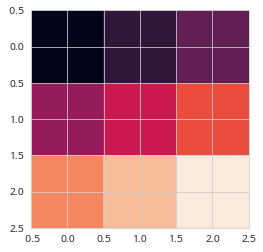

In [34]:
plt.imshow(np.arange(9).reshape(3, 3))

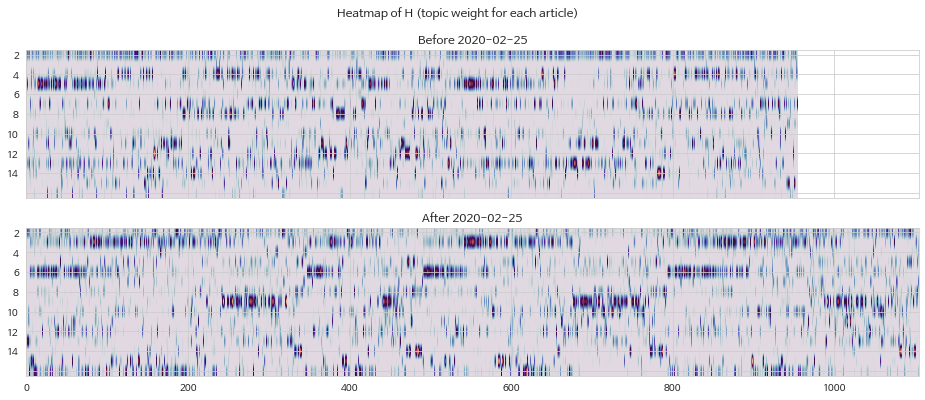

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)
axes[0].imshow(topics_before.T, cmap='twilight', aspect='auto')
axes[0].set_title(f'Before {split_date.date()}')
axes[1].imshow(topics_after.T, cmap='twilight', aspect='auto')
axes[1].set_title(f'After {split_date.date()}')
for ax in axes:
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_yticklabels(list(range(0, K + 1, 2)))
fig.suptitle("Heatmap of H (topic weight for each article)")
plt.show()

언론사별 $H$

In [11]:
언론사 = ['경향신문', '한겨레', '조선일보', '동아일보']

H_by_source = {
    'Before': {
        k: nmf_tfidf.transform(
            tfidf_vectorizer.transform(
                [' '.join(x) for x in docs_tokenized_before[k]])) for k in 언론사},
    'After': {
        k: nmf_tfidf.transform(
            tfidf_vectorizer.transform(
                [' '.join(x) for x in docs_tokenized_after[k]])) for k in 언론사},
}

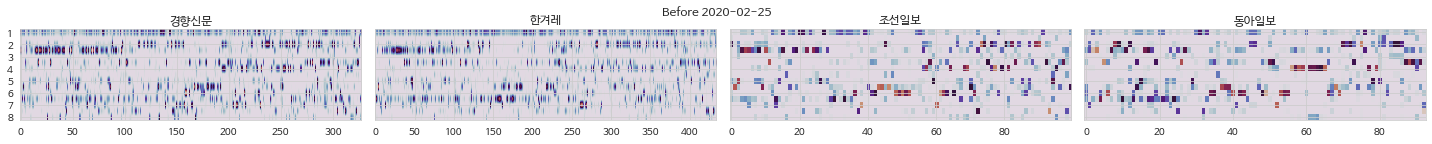

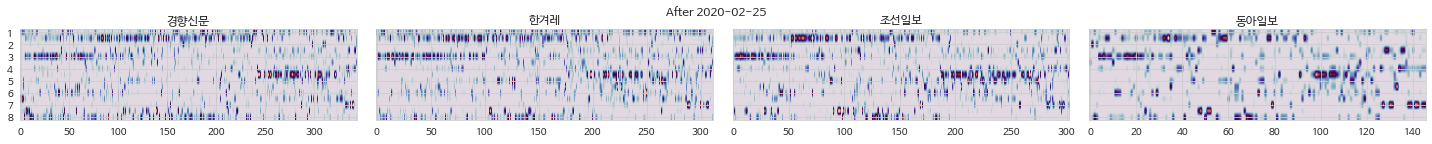

In [20]:
for group, d in H_by_source.items():
    fig, axes = plt.subplots(1, 4, figsize=(20, 2), sharey=True)
    for i, k in enumerate(언론사):
        H = d[k]
        axes[i].imshow(H.T, cmap='twilight', aspect='auto')
        axes[i].set_title(f'{k}')    
    for ax in axes:
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_yticklabels(list(range(0, 11)))
        
    fig.suptitle(f'{group} {split_date.date()}')
    plt.tight_layout()
    plt.show()

### How "orthogonal" are each topic?

In [11]:
H = nmf_tfidf.components_
H.shape

(10, 10000)

In [12]:
H_norm = np.linalg.norm(H, axis=1)[:, np.newaxis]
H_normed = H / H_norm
HHT_normed = np.dot(H_normed, H_normed.T)

In [13]:
H_norm

array([[2.88710964],
       [2.95415467],
       [2.53273056],
       [2.18713042],
       [2.27864188],
       [1.88842982],
       [2.00899188],
       [2.16129017],
       [1.89010808],
       [2.01916448]])

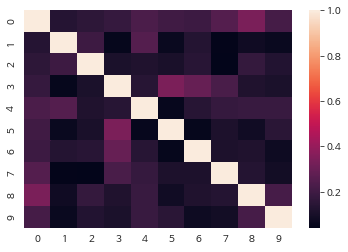

0.34375006115449247
(array([3, 5], dtype=int64), array([5, 3], dtype=int64))


In [21]:
sns.heatmap(HHT_normed)
plt.show()
max_elt = np.max(HHT_normed[HHT_normed < 0.9])
print(max_elt)
print(np.where(HHT_normed == max_elt))

Quite orthogonal!

### Topic Frequency

x-axis: **토픽 번호 - 1** (i.e. 1번 토픽은 0, 2번토픽은 1 위치에 있음)

#### ARGMAX

#### SUM

Make a summary dataset!!

In [17]:
dfHs = []
for t, d in H_by_source.items():
    for source, arr in d.items():
        dfH = dict()
        dfH['토픽'] = np.argmax(arr, axis=1) + 1
        dfH['sum_'] = np.sum(arr * H_norm.flatten() , axis=1) 
        dfH['언론사'] = source
        dfH['2020-02-25 전/후'] = '전' if t == 'Before' else '후'
        dfH['성향'] = '진보' if source in ['한겨레', '경향신문'] else '보수'
        dfH = pd.DataFrame(dfH)
        dfHs.append(dfH)

df = pd.concat(dfHs, axis=0, ignore_index=True)
df.head()

,토픽,sum_,언론사,2020-02-25 전/후,성향
0,4,0.635404,경향신문,전,진보
1,4,0.534759,경향신문,전,진보
2,9,0.357182,경향신문,전,진보
3,10,0.384970,경향신문,전,진보
4,1,0.387814,경향신문,전,진보


### Count

In [136]:
df.shape[0]

2060

In [244]:
bva = '2020-02-25 전/후'
df.groupby([bva]).size().rename('count').to_frame()

,count
2020-02-25 전/후,
전,955
후,1105


In [243]:
df.groupby([bva, '언론사']).size().unstack()

언론사,경향신문,동아일보,조선일보,한겨레
2020-02-25 전/후,,,,
전,328,93,100,434
후,344,146,303,312


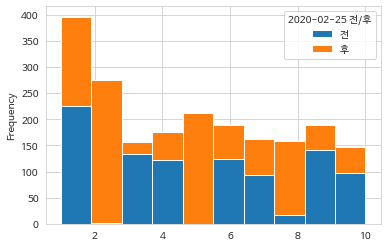

In [249]:
df.pivot(columns=bva).토픽.plot(kind='hist', stacked=True, bins=K)
plt.show()

In [250]:
count_전후 = df.groupby(['토픽', bva]).size().unstack(fill_value=0).stack().rename('개수').to_frame().reset_index()
count_전후

,토픽,2020-02-25 전/후,개수
0,1,전,226
1,1,후,170
2,2,전,1
3,2,후,274
4,3,전,133
5,3,후,23
6,4,전,122
7,4,후,54
8,5,전,0
9,5,후,211


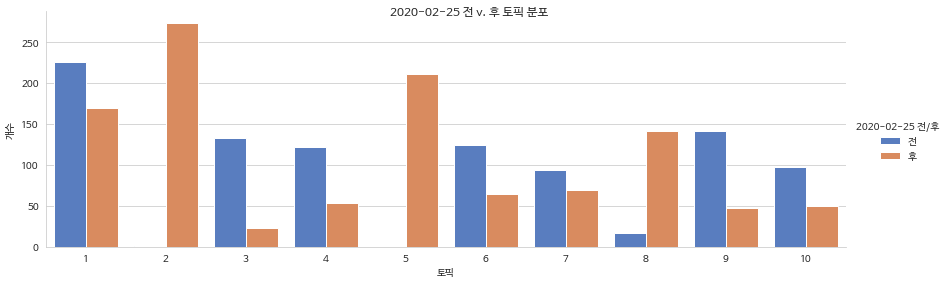

In [251]:
g = sns.catplot(x='토픽', y='개수', hue=bva, data=count_전후,
                height=4, aspect=12/4, kind="bar", palette='muted')
#g.despine(left=True)
g.fig.suptitle(f"{split_date.date()} 전 v. 후 토픽 분포")
plt.show()

In [252]:
count_전후_source = df.groupby(['토픽', bva, '언론사', '성향']).size().unstack(fill_value=0).stack().rename('개수').to_frame().reset_index()
count_전후_source

,토픽,2020-02-25 전/후,언론사,성향,개수
0,1,전,경향신문,보수,0
1,1,전,경향신문,진보,75
2,1,전,동아일보,보수,10
3,1,전,동아일보,진보,0
4,1,전,조선일보,보수,16
...,...,...,...,...,...
141,10,후,동아일보,진보,0
142,10,후,조선일보,보수,18
143,10,후,조선일보,진보,0
144,10,후,한겨레,보수,0


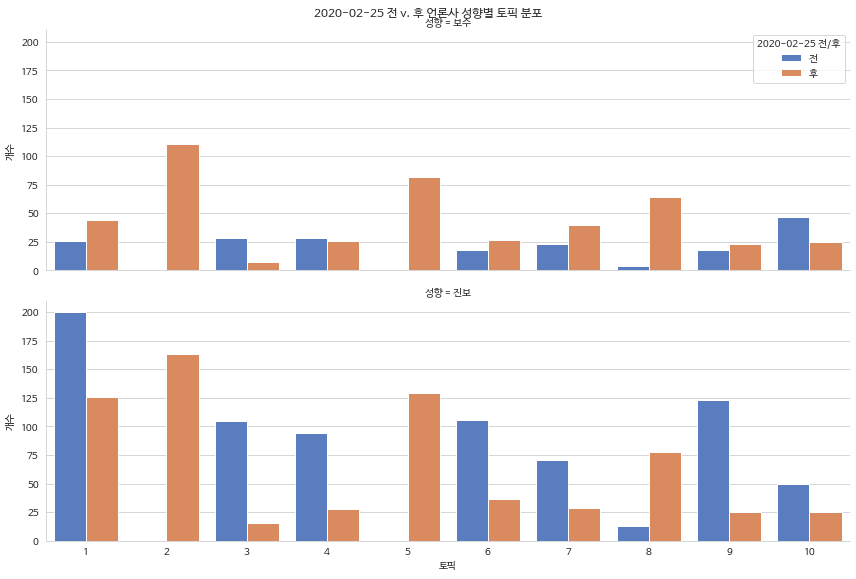

In [253]:
g = sns.catplot(x='토픽', y='개수', hue=bva, data=count_전후_source,
                row='성향', estimator=np.sum, ci=None, legend_out=False,
                height=4, aspect=12/4, kind="bar", palette='muted')
#g.despine(left=True)
g.fig.suptitle(f"{split_date.date()} 전 v. 후 언론사 성향별 토픽 분포", y=1.0)
plt.show()

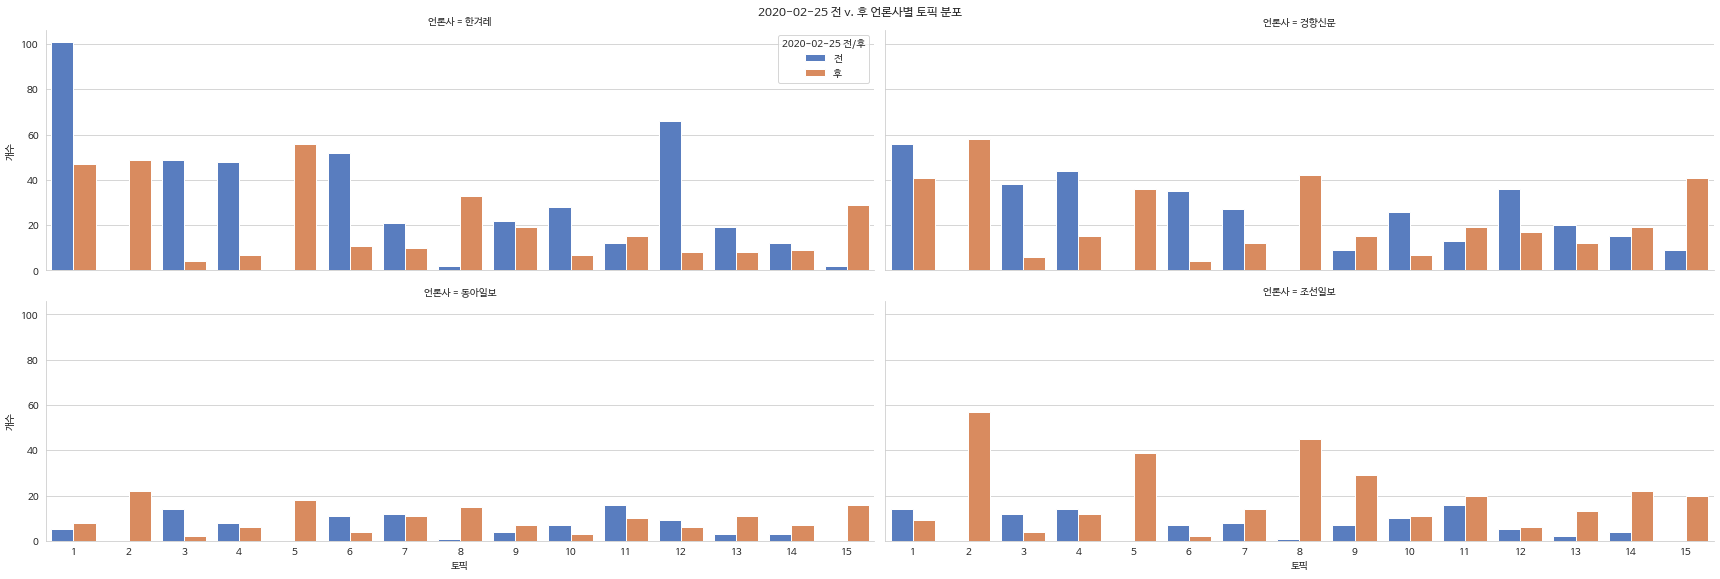

In [178]:
g = sns.catplot(x='토픽', y='개수', hue=bva, data=count_전후_source,
                col='언론사', col_wrap=2, col_order=['한겨레', '경향신문', '동아일보', '조선일보'], estimator=np.sum, ci=None, legend_out=False,
                height=4, aspect=12/4, kind="bar", palette='muted')
#g.despine(left=True)
g.fig.suptitle(f"{split_date.date()} 전 v. 후 언론사별 토픽 분포", y=1.0)
plt.show()

### By SUM * NORM

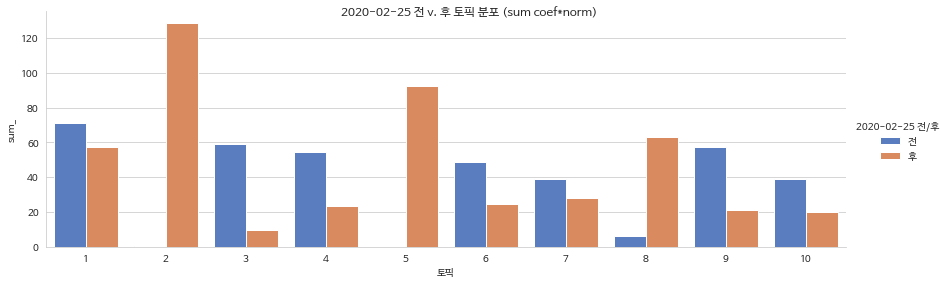

In [254]:
g = sns.catplot(x='토픽', y='sum_', hue=bva, data=df,
                height=4, aspect=12/4, estimator=np.sum, ci=None, kind="bar", palette='muted')
#g.despine(left=True)
g.fig.suptitle(f"{split_date.date()} 전 v. 후 토픽 분포 (sum coef*norm)")
plt.show()

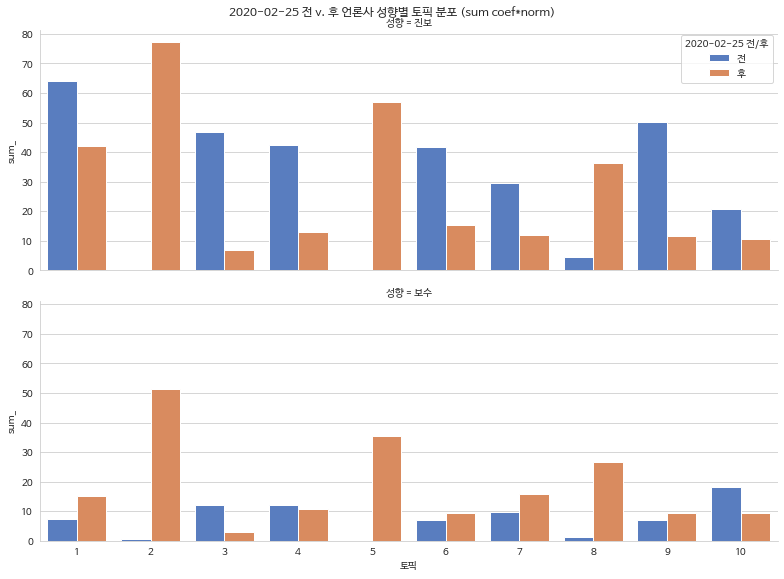

In [256]:
g = sns.catplot(x='토픽', y='sum_', hue=bva, data=df,
                row='성향', estimator=np.sum, ci=None, legend_out=False,
                height=4, aspect=11/4, kind="bar", palette='muted')
#g.despine(left=True)
g.fig.suptitle(f"{split_date.date()} 전 v. 후 언론사 성향별 토픽 분포 (sum coef*norm)", y=1.0)
plt.show()

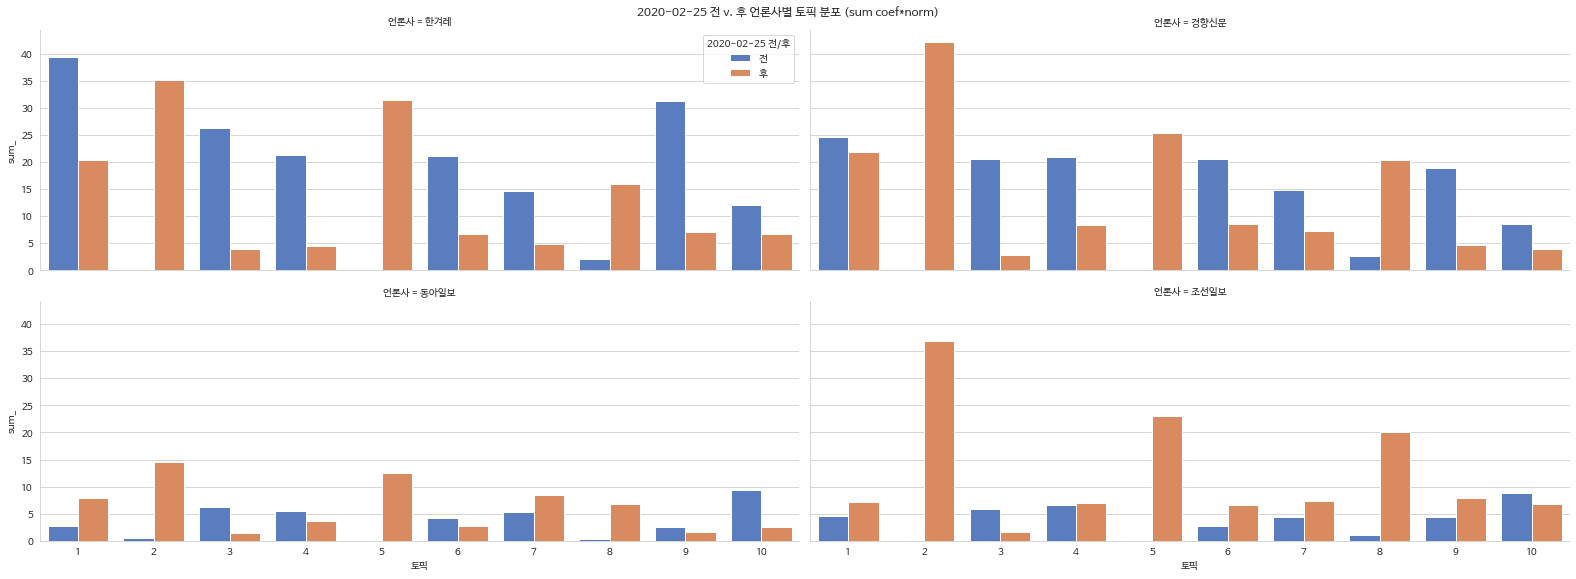

In [257]:
g = sns.catplot(x='토픽', y='sum_', hue=bva, data=df,
                col='언론사', col_wrap=2, col_order=['한겨레', '경향신문', '동아일보', '조선일보'], estimator=np.sum, ci=None, legend_out=False,
                height=4, aspect=11/4, kind="bar", palette='muted')
#g.despine(left=True)
g.fig.suptitle(f"{split_date.date()} 전 v. 후 언론사별 토픽 분포 (sum coef*norm)", y=1.0)
plt.show()

In [ ]:
marginal_topic_dis

TODO

[ ] 언론사별 분석

[ ] 토픽 분포 visualize (not simply argmax!!)

[ ] 샘플 기사 ID 추출

[ ] 2, 3 gram? without removing EJX

# 대표ㅣ사 추출

In [192]:
topic_arr = np.argmax(arr * H_norm.flatten(), axis=1) + 1
for T in range(1, 16):
    print({T: np.where(topic_arr == T)[0]})

[ 53  54  60  61  71  83  86  90  96 109 121 140]
[ 7  8 14 28 30 31 32 33 34 37 38 39 40 45 49 56 57 58 59 65 72 77 78 81
 84 85 88 89 93 94]
[1 3]
[ 43  47 128 129 135 136]
[  4   5   6   9  12  13  15  16  17  18  19  20  21  22  23  27  42  44
  66 103 120 132]
[  0  10 117 137]
[ 25  46  62 112 116 123 126 134]
[ 82  91  97  98  99 100 101 102 104 105 106 107 111 115 143]
[ 74  75 113 114 118 122]
[ 35 133]
[ 11  29  73  76  80  95 124]
[ 92 108 110 119]
[ 79  87 127 130 131 138 139 141 142 144 145]
[24 48 51 52 67]
[  2  26  36  41  50  55  63  64  68  69  70 125]


In [193]:
from collections import defaultdict

In [200]:
D = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
D['Hi']['Ho']['He']

{}

In [204]:
_d = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for t, d in H_by_source.items():
    for source, arr in d.items():
        topic_arr = np.argmax(arr * H_norm.flatten(), axis=1) + 1
        for T in range(1, 16):
            _d[t][source][T] = np.where(topic_arr == T)[0].astype(np.int16)

In [18]:
topic_dfs = dict()
for source, _df in dfs.items():
    _df = _df[['title', 'summary', 'text', ]]
    for t, d in H_by_source.items():
        arr = d[source]
        mask = _df.index < split_date if t=='Before' else _df.index >= split_date
        _df.loc[mask, f'topic_id'] = np.argmax(arr * H_norm.flatten(), axis=1) + 1
        _df.loc[mask, f'topic_id_weight'] = np.max(arr * H_norm.flatten(), axis=1)
    _df.loc[:, 'topic_id'] = _df['topic_id'].astype(int)
    #_df.reset_index().to_csv(PROJECT_DIR / 'data'/ 'processed'/ f'{source}_topics.csv', index=False)
    topic_dfs[source] = _df

C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [21]:
from IPython.display import display, Markdown

In [33]:
대표기사 = []

for source, _df in topic_dfs.items():
    # get dataframe sorted by life Expectancy in each continent 
    g = _df.groupby(["topic_id"]).apply(
        lambda x: x.sort_values(["topic_id_weight"], ascending=False)
    ).reset_index(level=0, drop=True)
    
    # select top N rows within each continent
    g = g.groupby('topic_id').head(3)
    g.loc[:, 'source'] = source
    g = g[['source', 'topic_id', 'topic_id_weight', 'title', 'summary', 'text']]
    대표기사.append(g)
    
대표기사 = pd.concat(대표기사, axis=0)
#     display(Markdown(f"### {source}"))
#     display()

In [37]:
대표기사.reset_index().to_csv(PROJECT_DIR / 'data' / 'processed' / f'대표기사_max_features-{max_features}-max_df-{max_df}-min_df-{min_df}-ngrams-{ngram_range[1]}-{model_suffix}.csv')

가중치

In [42]:
for source, _df in dfs.items():
    _df = _df[['title', 'summary', 'text', ]]
    for t, d in H_by_source.items():
        arr = d[source]
        mask = _df.index < split_date if t=='Before' else _df.index >= split_date
        topic_weights = arr * H_norm.flatten()
        print(topic_weights.shape)
        print(topic_weights.sum(axis=1))
        break
    break


(328, 10)
[0.6354036  0.53475918 0.35718246 0.38497039 0.38781355 0.29676743
 0.42509694 0.20865204 0.32047049 0.54865829 0.22790123 0.34724809
 0.35776917 0.25770288 0.34620904 0.6237787  0.59112206 0.42884388
 0.48897826 0.44126133 0.42079791 0.31975041 0.42483752 0.32280804
 0.47365557 0.62491871 0.46501385 0.82356666 0.48212691 0.49736857
 0.38659816 0.39148439 0.20411631 0.40097807 0.43076514 0.46372006
 0.52686002 0.44106027 0.51862771 0.35225961 0.42985972 0.44766555
 0.44782307 0.27189776 0.4126949  0.46911545 0.18236526 0.42552335
 0.41247543 0.58236169 0.57107204 0.44902915 0.44134795 0.46195335
 0.33393056 0.46633342 0.53547859 0.48446925 0.29398087 0.31457224
 0.49915248 0.35121691 0.31036385 0.82290287 0.44492745 0.45443061
 0.37616524 0.33878637 0.69923583 0.11639978 0.45665325 0.3139086
 0.50917391 0.50355367 0.42032044 0.45839707 0.37854534 0.40768139
 0.47878021 0.5260188  0.50808596 0.27907014 0.25716831 0.47960655
 0.40943754 0.40558202 0.54221597 0.52866057 0.413299

# TODO

1. 샘플 기사 (구글시트에서..)
2. presentation 준비
3. Orthonormality 체크..